In [24]:
#PyTorch CIFAR-10 local training

In [25]:
!/bin/bash ./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [26]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

In [27]:
role

'arn:aws:iam::499554417458:role/service-role/AmazonSageMaker-ExecutionRole-20220118T162294'

In [28]:
import os
import subprocess

instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

Instance type = local


In [29]:
# Download cifar-10
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


      dog       cat     horse       dog


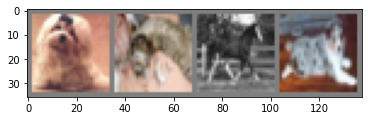

In [30]:
# Data preview
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

In [31]:
# Upload the data
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar10")

y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,250 [INFO ] pool-2-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:81bab6600239,timestamp:1642505212
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,252 [INFO ] pool-2-thread-1 TS_METRICS - DiskAvailable.Gigabytes:8.167774200439453|#Level:Host|#hostname:81bab6600239,timestamp:1642505212
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,253 [INFO ] pool-2-thread-1 TS_METRICS - DiskUsage.Gigabytes:99.94622802734375|#Level:Host|#hostname:81bab6600239,timestamp:1642505212
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,253 [INFO ] pool-2-thread-1 TS_METRICS - DiskUtilization.Percent:92.4|#Level:Host|#hostname:81bab6600239,timestamp:1642505212
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,254 [INFO ] pool-2-thread-1 TS_METRICS - MemoryAvailable.Megabytes:2212.515625|#Level:Host|#hostname:81bab6600239,timestamp:1642505212
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:26:52,255 [INFO ] pool-2-thread-1 TS_METRICS - MemoryUsed.Megabytes:147

In [33]:
# Construct a script for training
!pygmentize source/cifar10.py

import argparse
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

try:
    from sagemaker_inference import environment
except:
    from sagemaker_training import environment

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        s

Script Functions
SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

Predicting Functions
model_fn(model_dir) - loads your model.
input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
output_fn(prediction_output, accept) - serializes predictions from predict_fn.
predict_fn(input_data, model) - calls a model on data deserialized in input_fn.
The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker.

Create a training job using the sagemaker.PyTorch estimator
The PyTorch class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu". In this case, instance_type was set above based on your whether you're running a GPU instance.

After we've constructed our PyTorch object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.

In [34]:
from sagemaker.pytorch import PyTorch

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    instance_type=instance_type,
)

cifar10_estimator.fit(inputs)

Creating 799m1m49rl-algo-1-xjof1 ... 
Creating 799m1m49rl-algo-1-xjof1 ... done
Attaching to 799m1m49rl-algo-1-xjof1
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:16,937 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:16,940 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:16,952 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:16,970 sagemaker_pytorch_container.training INFO     Invoking user training script.
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:17,256 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:17,272 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
799m1m49rl-algo-1-xjof1 | 2022-01-18 11:27:17,287 sagemaker-training-toolkit 

In [35]:
print(torch.__version__)

1.7.1


Deploy the trained model to prepare for predictions
The deploy() method creates an endpoint (in this case locally) which serves prediction requests in real-time.

In [36]:
from sagemaker.pytorch import PyTorchModel

cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1, instance_type=instance_type)

!y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:50,919 [INFO ] pool-1-thread-5 ACCESS_LOG - /172.18.0.1:51216 "GET /ping HTTP/1.1" 200 13
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:50,921 [INFO ] pool-1-thread-5 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:81bab6600239,timestamp:null
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:52,366 [INFO ] pool-2-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:81bab6600239,timestamp:1642505752
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:52,366 [INFO ] pool-2-thread-1 TS_METRICS - DiskAvailable.Gigabytes:7.829311370849609|#Level:Host|#hostname:81bab6600239,timestamp:1642505752
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:52,366 [INFO ] pool-2-thread-1 TS_METRICS - DiskUsage.Gigabytes:100.2846908569336|#Level:Host|#hostname:81bab6600239,timestamp:1642505752
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:35:52,366 [INFO ] pool-2-thread-1 TS_METRICS - DiskUtilization.Percent:92.8|#Level:Host|#hostname:81bab6600239,timestamp:1642505752
y

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 837, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 899, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 842, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpgh1gy8k7/docker-compose.yaml', 'up', '--build', '--abort-on-containe

Invoking the endpoint

GroundTruth:   cat ship ship plane
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,243 [INFO ] W-9001-model_1 org.pytorch.serve.wlm.WorkerThread - Backend response time: 38
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,243 [INFO ] W-9001-model_1 ACCESS_LOG - /172.18.0.1:51224 "POST /invocations HTTP/1.1" 200 52
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,244 [INFO ] W-9001-model_1 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:81bab6600239,timestamp:null
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,244 [INFO ] W-9001-model_1 TS_METRICS - QueueTime.ms:0|#Level:Host|#hostname:81bab6600239,timestamp:null
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,266 [INFO ] W-9001-model_1 TS_METRICS - WorkerThreadTime.ms:25|#Level:Host|#hostname:81bab6600239,timestamp:null
Predicted:  frog ship ship plane
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:25,267 [INFO ] W-9001-model_1-stdout MODEL_METRICS - PredictionTime.Milliseconds:35.46|#ModelName:model,Level:Model|#hostname:81bab6600239,requestI

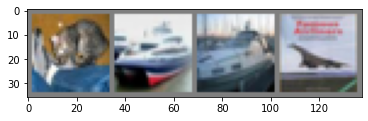

In [37]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

Clean-up
Deleting the local endpoint when you're finished is important, since you can only run one local endpoint at a time.

In [38]:
#if not working, delete manually
cifar10_estimator.delete_endpoint()

The function delete_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:81bab6600239,timestamp:1642505812
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - DiskAvailable.Gigabytes:7.813762664794922|#Level:Host|#hostname:81bab6600239,timestamp:1642505812
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - DiskUsage.Gigabytes:100.30023956298828|#Level:Host|#hostname:81bab6600239,timestamp:1642505812
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - DiskUtilization.Percent:92.8|#Level:Host|#hostname:81bab6600239,timestamp:1642505812
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - MemoryAvailable.Megabytes:2229.0|#Level:Host|#hostname:81bab6600239,timestamp:1642505812
y4zr2syzky-algo-1-bj5n0 | 2022-01-18 11:36:52,527 [INFO ] pool-2-thread-1 TS_METRICS - MemoryUsed.Megabytes:1455.31